In [0]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import LightSource

%matplotlib inline
%config InlineBackend.figure_format = 'svg'

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
%cd /content/drive/My Drive/imagenes
import os
from PIL import Image
import torchvision.transforms as transforms
directory = os.getcwd()
images = []

toTensor = transforms.ToTensor()
for f in os.listdir(directory):
    im = Image.open(f)
    im_tensor = toTensor(im)
    preprocess = transforms.Compose([
    transforms.Resize(224),
    transforms.ToTensor(),])
    im_tensor = preprocess(im)[None,:,:,:]

    images.append(im_tensor)

#print(images[0].shape) #torch.Size([3, 375, 500])
#plt.imshow(images[0].numpy().transpose(1,2,0))  #torch.Size([375, 500, 3])
#print(images[0])
#images = np.array(images)

/content/drive/My Drive/imagenes


553

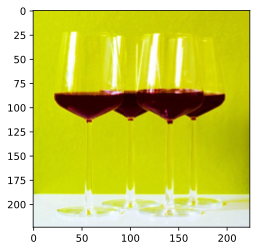

In [0]:
plt.imshow(images[549][0].numpy().transpose(1,2,0))

In [0]:
img_name = os.path.join(directory,os.listdir(directory)[187])
print(img_name)
a = os.listdir(directory)[552]
print(a)

/content/drive/My Drive/imagenes/n01910747_36.jpg
n07891726_54.jpg


In [0]:
import torch
import torch.nn as nn
from torchvision import models#Modulo para normalizar las imagenes y que sean compatibles con la red pre-entrenada vgg16

class Normalize(nn.Module):
    def __init__(self, mean, std):
        super(Normalize, self).__init__()
        self.mean = torch.Tensor(mean)
        self.std = torch.Tensor(std)
    def forward(self, x):
        return (x - self.mean.type_as(x)[None,:,None,None]) / self.std.type_as(x)[None,:,None,None]

# from https://github.com/pytorch/examples/blob/master/imagenet/main.py
norm = Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

model = models.vgg16(pretrained=True)
model.eval();

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:09<00:00, 59.9MB/s]


#Para analizar todas las imagenes se debe trabajar en subconjuntos de 120 en 120 porque al trabajarlas todas juntas se provoca un crush en la sesióón del colab

In [0]:
predicciones = list()
i = 0
while i < 120:
  pred = model(norm(images[i])) #Se normalizan las imagenes
  predicciones.append(pred)
  i += 1


torch.Size([1, 3, 224, 298]) 0


In [0]:
%cd /content/drive/My Drive/
#importar clases del modelo y ver el indice en que están
import json
with open("imagenet_class_index.json") as f:
    imagenet_classes = {int(i):x[1] for i,x in json.load(f).items()}
clases = list()
index = list()
j = 0
while j < len(predicciones):
  p = predicciones[j]
  clase = imagenet_classes[p.max(dim=1)[1].item()]
  i= 0
  while i < len(imagenet_classes):
    if clase == imagenet_classes[i]:
      break
    i += 1
  index.append(i)
  j+=1
  clases.append(clase)


/content/drive/My Drive


In [0]:
#PGD con 10 iteraciones por imagen
import torch.optim as optim
epsilon = 0.04
adv = list()
i = 0
j = 0
while i < 0 + len(predicciones):
  delta = torch.zeros_like(images[i], requires_grad=True) #Se define delta como el tamaño de images[i]
  opt = optim.SGD([delta], lr=1e-1)
  print("Imagen {}".format(i))
  for t in range(10):
      pred = model(norm(images[i] + delta))  #aqui tambien se suma images[i] y delta pero no hay problema
      a = index[j]
      loss = -nn.CrossEntropyLoss()(pred, torch.LongTensor([a]))
      if t == 0 or t == 9:
          print("Iteración {0:d}, loss: {1:.3f}".format(t, loss.item()))
      opt.zero_grad()
      loss.backward()
      opt.step()
      delta.data.clamp_(-epsilon, epsilon)
  j += 1 
  adv.append(pred)
  i+=1


tensor([[[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]],

         [[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]],

         [[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]]], requires_grad=True)
Imagen 0
Iteración 0, loss: -0.013
Iteración 9, loss: -35.376


In [0]:
#Se imprimen las clases y la probabilidad que predice la red de los ejemplos adversarios al usar PGD
i = 0
clases_adv = list()
prob_pred = list()
while i < len(adv):
  pred_adv = adv[i]
  max_class = pred_adv.max(dim=1)[1].item()
  print("Predicted class: ", imagenet_classes[max_class])
  print("Predicted probability:", nn.Softmax(dim=1)(pred_adv)[0,max_class].item())
  prob = nn.Softmax(dim=1)(pred_adv)[0,max_class].item()
  prob_pred.append(prob)
  clases_adv.append(imagenet_classes[max_class])
  i +=1 

Predicted class:  killer_whale
Predicted probability: 1.0


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


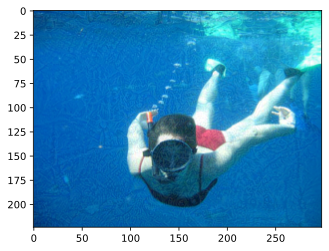

In [0]:
adversario = images[0] + delta
plt.imshow(adversario[0].detach().numpy().transpose(1,2,0))

In [0]:
#suma de la probabilidad de confianza con la que se predicen las imágenes 
suma1 = 0
for prob in prob_pred:
  suma1 += prob
print(suma1)

71.53213036060333


In [0]:
#plt.imshow((images[30] + delta)[0].detach().numpy().transpose(1,2,0))
print(delta.shape)
print(images[30].shape)
print(images[99].shape)
#images[99] tiene un tamaño distinto al resto de elementos de la lista, hay que cortarlo 

torch.Size([1, 3, 224, 398])
torch.Size([1, 3, 224, 298])
torch.Size([1, 3, 224, 398])


In [0]:
#clases reales del dataset elegido 
clases_reales = ['snorkel','goldfish','koala','jellyfish','Lhasa','gazelle','missile','mushroom','orange', 'red_wine']

number = 0
etiquetas_reales = list()
for i in range(559):
  etiquetas_reales.append(clases_reales[number])
  if i%60 == 59:
    number += 1

print(etiquetas_reales)


['snorkel', 'snorkel', 'snorkel', 'snorkel', 'snorkel', 'snorkel', 'snorkel', 'snorkel', 'snorkel', 'snorkel', 'snorkel', 'snorkel', 'snorkel', 'snorkel', 'snorkel', 'snorkel', 'snorkel', 'snorkel', 'snorkel', 'snorkel', 'snorkel', 'snorkel', 'snorkel', 'snorkel', 'snorkel', 'snorkel', 'snorkel', 'snorkel', 'snorkel', 'snorkel', 'snorkel', 'snorkel', 'snorkel', 'snorkel', 'snorkel', 'snorkel', 'snorkel', 'snorkel', 'snorkel', 'snorkel', 'snorkel', 'snorkel', 'snorkel', 'snorkel', 'snorkel', 'snorkel', 'snorkel', 'snorkel', 'snorkel', 'snorkel', 'snorkel', 'snorkel', 'snorkel', 'snorkel', 'snorkel', 'snorkel', 'snorkel', 'snorkel', 'snorkel', 'snorkel', 'goldfish', 'goldfish', 'goldfish', 'goldfish', 'goldfish', 'goldfish', 'goldfish', 'goldfish', 'goldfish', 'goldfish', 'goldfish', 'goldfish', 'goldfish', 'goldfish', 'goldfish', 'goldfish', 'goldfish', 'goldfish', 'goldfish', 'goldfish', 'goldfish', 'goldfish', 'goldfish', 'goldfish', 'goldfish', 'goldfish', 'goldfish', 'goldfish', 'go

In [0]:
wrong1 = 0 #cantidad de imagenes mal clasificadas luego de usar el metodo PGD
for n in range(len(predicciones)):
  if clases[n] != etiquetas_reales[n]:
     continue
  else:
    if(clases[n] != clases_adv[n]):
      wrong1 += 1

print(wrong1)

20


In [0]:
#predicciones erroneas hechas por vgg16 antes de usar ejemplos adversarios
predicciones_malas_1 = 0

for i in range(len(predicciones)):
  if clases[i] != etiquetas_reales[i]:
    predicciones_malas_1 += 1

print(predicciones_malas_1)

55


In [0]:
#wrong_total es el total de imagenes mal clasificadas luego de usar imagenes adversarios.
#Las variables wrong1, wrong2, etc corresponden a cada subconjunto de 120 imágenes. Lo mismo ocurre para la variable predicciones_malas_total
wrong_total = wrong1 + wrong2 + wrong3 + wrong4 +wrong5 
predicciones_malas_total = predicciones_malas_1 + predicciones_malas_2 + predicciones_malas_3 + predicciones_malas_4 + predicciones_malas_5

291


In [0]:
#tasa de predicciones incorrectas al usar pgd
misclassification_rate = wrong_total/(len(images)-predicciones_malas_total)
print(misclassification_rate)

0.6870229007633588


In [0]:
suma_total = suma1 + suma2 + suma3 + suma4 + suma5 

In [0]:
#promedio de confianza en las predicciones
avg_pred = suma_total/ len(images)
print(avg_pred)

0.9703485828708136


In [0]:
#metodo FGSM
import torch
import torch.nn as nn
import torch.optim as optim
epsilon = 0.04
adv_fgsm_list = list()
i = 0
j = 0
while i < 0 + len(predicciones):
  a = index[j]
  j += 1
  delta = torch.zeros_like(images[i], requires_grad=True)
  pred = model(norm(images[i] + delta))
  loss = nn.CrossEntropyLoss()(pred, torch.LongTensor([a]))
  loss.backward()
  perturbacion = epsilon * delta.grad.detach().sign()
  adv_fgsm = images[i] + perturbacion
  adv_fgsm_list.append(adv_fgsm)
  i += 1


tensor([[[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]],

         [[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]],

         [[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]]], requires_grad=True)
tensor([[[[ 5.9319e-05, -1.2028e-04, -9.8634e-05,  ...,  3.5249e-06,
            3.8845e-06,  6.1680e-06],
          [-1.5782e-05, -1.0737e-04, -4.5772e-05,  ...,  2.5545e-

In [0]:
#Se imprimen las clases y la probabilidad que predice la red de los ejemplos adversarios al usar FGSM
i = 0
pred_fgsm = list()
clases_adv_fgsm = list()
prob_pred_fgsm = list()
while i< len(adv_fgsm_list):
  pred_adv = model(norm(adv_fgsm_list[i]))
  max_class = pred_adv.max(dim=1)[1].item()
  print("Predicted class: ", imagenet_classes[max_class])
  print("Predicted probability:", nn.Softmax(dim=1)(pred_adv)[0,max_class].item())
  pred_fgsm = nn.Softmax(dim=1)(pred_adv)[0,max_class].item()
  prob_pred_fgsm.append(pred_fgsm)
  clases_adv_fgsm.append(imagenet_classes[max_class])
  i +=1 


Predicted class:  scuba_diver
Predicted probability: 0.18245497345924377


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


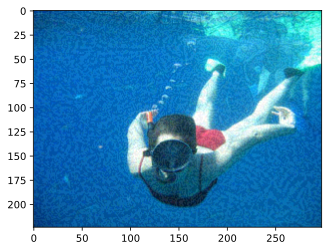

In [0]:
plt.imshow(adv_fgsm[0].detach().numpy().transpose(1,2,0))

In [0]:
suma_fgsm1 = 0
for prob in prob_pred_fgsm:
  suma_fgsm1 += prob
print(suma_fgsm5)

24.579006747808307


In [0]:
wrong1_fgsm = 0 #cantidad de imagenes mal clasificadas luego de usar el metodo PGD
for n in range(len(clases_adv_fgsm)):
  if clases[n] != etiquetas_reales[n+480]:
     continue
  else:
    if(clases[n] != clases_adv_fgsm[n]):
      wrong1_fgsm += 1

print(wrong1_fgsm)

20


In [0]:
wrong_total_fgsm = wrong1_fgsm + wrong2_fgsm + wrong3_fgsm + wrong4_fgsm +wrong5_fgsm
print(wrong_total_fgsm)

247


In [0]:
suma_total_fgsm = suma_fgsm1 + suma_fgsm2 + suma_fgsm3 + suma_fgsm4 + suma_fgsm5
print(suma_total) 

536.60276632756


In [0]:
misclassification_rate_fgsm = wrong_total_fgsm/(len(images)-predicciones_malas_total)
print(misclassification_rate_fgsm)

0.9427480916030534


In [0]:
avg_pred_fgsm = suma_total_fgsm/ len(images)
print(avg_pred_fgsm)

0.35527010882360893
